# Exercise
Do your work for this exercise in a notebook named `explore`. Use the techniques in the lesson to explore the `store item demand` dataset and the `opsd` dataset.

For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. For both datasets you should choose a method of splitting your data and only explore the training split.

> 1. "random noise" is a slightly innacurate way to describe this component. Technically this component is the residual, or the error in our prediction. Similar to when we are examining linear regression models, any pattern observed in the residuals of our model tell us that the model failed to capture that pattern. ↩

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# from acquire import all_sales, open_power_systems_data as opsd
from prepare import prepare_opsd, prepare_sales
from wrangle import summarize


In [4]:
import statsmodels.api as sm

# plotting defaults
plt.rc('figure', figsize=(11, 5))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)


In [36]:
from datetime import datetime

In [9]:
df = prepare_sales()

In [10]:
df

,item,sale_amount,sale_date,sale_id,store,store_address,store_city,store_state,store_zipcode,item_brand,item_name,item_price,item_upc12,item_upc14,weekday,month,sales_total
sale_date,,,,,,,,,,,,,,,,,
2013-01-01,1,13.0,2013-01-01,1,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Tue,1,10.92
2013-01-02,1,11.0,2013-01-02,2,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Wed,1,9.24
2013-01-03,1,14.0,2013-01-03,3,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Thu,1,11.76
2013-01-04,1,13.0,2013-01-04,4,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Fri,1,10.92
2013-01-05,1,10.0,2013-01-05,5,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,Sat,1,8.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,50,63.0,2017-12-27,912996,10,8503 NW Military Hwy,San Antonio,TX,78231,Choice,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221,Wed,12,327.60
2017-12-28,50,59.0,2017-12-28,912997,10,8503 NW Military Hwy,San Antonio,TX,78231,Choice,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221,Thu,12,306.80
2017-12-29,50,74.0,2017-12-29,912998,10,8503 NW Military Hwy,San Antonio,TX,78231,Choice,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221,Fri,12,384.80


In [11]:
df.shape

(913000, 17)

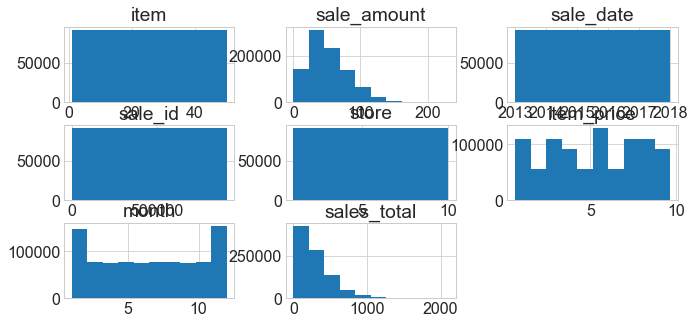

In [12]:

df.hist()

plt.show()

In [13]:
# Percentage-Based
# establish that I want about 70% of my data here:
train_size = 0.70
# get that in row numbers:
n = df.shape[0]
test_start_index = round(train_size*n)

In [16]:
test_start_index

639100

### Prepare df

#### df.sort_index()

In [23]:
df = df.sort_index()

In [28]:
df.groupby(df.index).sales_total.agg(['max', 'mean', 'min'])

,max,mean,min
sale_date,,,
2013-01-01,592.15,147.68802,4.44
2013-01-02,646.81,147.14116,3.36
2013-01-03,610.37,156.33896,6.72
2013-01-04,619.48,168.93546,4.20
2013-01-05,756.13,175.24370,5.40
...,...,...,...
2017-12-27,956.55,218.30230,7.20
2017-12-28,857.28,234.75498,6.72
2017-12-29,920.11,253.08368,10.44


In [32]:
sales_by_day = df.groupby(df.index).sales_total.agg(['max', 'mean', 'min'])

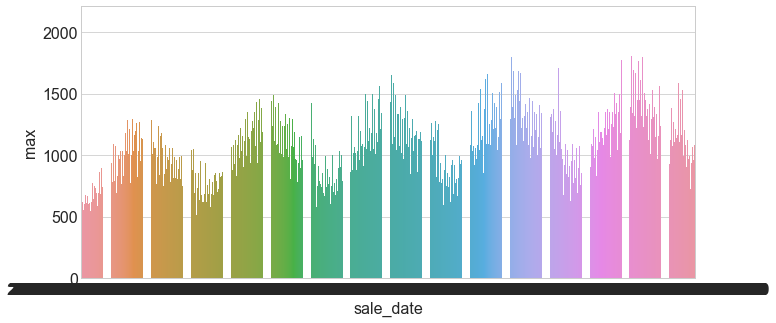

In [34]:
sns.barplot(data= sales_by_day,
            x=sales_by_day.index,
            y='max')

plt.show()

In [35]:
df.index.unique()

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='sale_date', length=1826, freq=None)

#### df.drop(columns='sale_date')

In [79]:
df = df.drop(columns='sale_date')

#### set basics

In [90]:
df.columns

Index(['item', 'sale_amount', 'sale_id', 'store', 'store_address',
       'store_city', 'store_state', 'store_zipcode', 'item_brand', 'item_name',
       'item_price', 'item_upc12', 'item_upc14', 'weekday', 'month',
       'sales_total'],
      dtype='object')

In [95]:
df[['item', 'store', 'item_brand', 'item_name',
       'item_price', 'weekday', 'month',
       'sales_total']]

,item,store,store_zipcode,item_brand,item_name,item_price,weekday,month,sales_total
sale_date,,,,,,,,,
2013-01-01,1,1,78253,Riceland,Riceland American Jazmine Rice,0.84,Tue,1,10.92
2013-01-01,12,7,78217,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,Tue,1,218.40
2013-01-01,46,7,78217,Mama Marys,Pizza Sauce,4.65,Tue,1,125.55
2013-01-01,12,8,78232,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,Tue,1,453.60
2013-01-01,12,9,78221,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,Tue,1,294.00
...,...,...,...,...,...,...,...,...,...
2016-12-31,18,6,78220,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,Sat,12,263.40
2016-12-31,42,1,78253,Moms Best Naturals,Moms Best Naturals Cereal Toasted Cinnamon Squ...,2.97,Sat,12,92.07
2016-12-31,6,4,78204,Sally Hansen,Sally Hansen Nail Color Magnetic 903 Silver El...,6.93,Sat,12,284.13


In [96]:
basics = ['item', 'store', 'item_brand', 'item_name',
       'item_price', 'weekday', 'month',
       'sales_total']

In [97]:
df = df[basics]

In [98]:
train = df[:test_start_index] # everything up to (not including) test start index
test = df[test_start_index:] # everything from test start index onward

In [99]:
train.shape[0] + test.shape[0] == df.shape[0]

True

In [100]:
pd.concat([train.tail(1), test.head(1)])

,item,store,item_brand,item_name,item_price,weekday,month,sales_total
sale_date,,,,,,,,
2016-07-02,47,5,Bear Naked,Bear Naked Fit Almond Crisp 100 Percent Natura...,7.38,Sat,7,221.40
2016-07-02,3,3,Earths Best,Earths Best Organic Fruit Yogurt Smoothie Mixe...,2.43,Sat,7,162.81


In [101]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 639100 entries, 2013-01-01 to 2016-07-02
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   item         639100 non-null  int64  
 1   store        639100 non-null  int64  
 2   item_brand   639100 non-null  object 
 3   item_name    639100 non-null  object 
 4   item_price   639100 non-null  float64
 5   weekday      639100 non-null  object 
 6   month        639100 non-null  int64  
 7   sales_total  639100 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 43.9+ MB


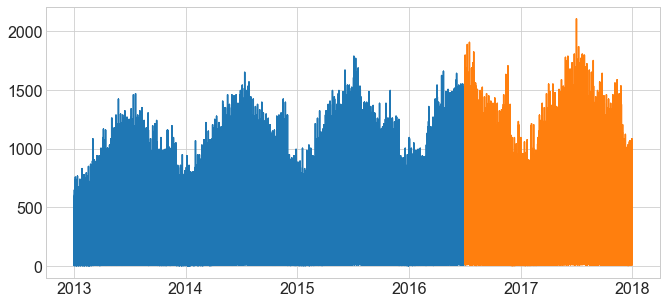

In [102]:
plt.plot(train.index, train.sales_total)
plt.plot(test.index, test.sales_total)
plt.show()

#### Train-Test split

In [103]:
# Human-Based
train = df.loc[:'2016']
test = df.loc['2017']


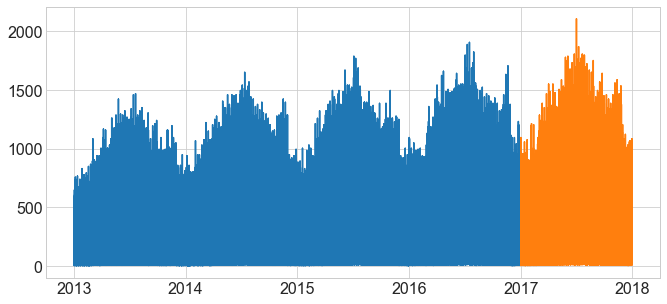

In [104]:
plt.plot(train.index, train.sales_total)
plt.plot(test.index, test.sales_total)
plt.show()

#### TimeSeriesSplit
`sklearn.model_selection.TimeSeriesSplit`

In [52]:
from sklearn.model_selection import TimeSeriesSplit

In [60]:
tss = TimeSeriesSplit(n_splits=5)

In [61]:
tss.split(df)

<generator object TimeSeriesSplit.split at 0x2be1df4a0>

In [87]:
# for train_index, test_index in tss.split(df):
#     print('Train:', train_index, 'Test:', test_index)
#     train, test = df[train_index], df[test_index]

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
>>> for train_index, test_index in tscv.split(X):
...     print("TRAIN:", train_index, "TEST:", test_index)
...     X_train, X_test = X[train_index], X[test_index]
...     y_train, y_test = y[train_index], y[test_index]
TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]
>>> # Fix test_size to 2 with 12 samples
>>> X = np.random.randn(12, 2)
>>> y = np.random.randint(0, 2, 12)
>>> tscv = TimeSeriesSplit(n_splits=3, test_size=2)
>>> for train_index, test_index in tscv.split(X):
...    print("TRAIN:", train_index, "TEST:", test_index)
...    X_train, X_test = X[train_index], X[test_index]
...    y_train, y_test = y[train_index], y[test_index]
TRAIN: [0 1 2 3 4 5] TEST: [6 7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [8 9]
TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10 11]
>>> # Add in a 2 period gap
>>> tscv = TimeSeriesSplit(n_splits=3, test_size=2, gap=2)
>>> for train_index, test_index in tscv.split(X):
...    print("TRAIN:", train_index, "TEST:", test_index)
...    X_train, X_test = X[train_index], X[test_index]
...    y_train, y_test = y[train_index], y[test_index]
TRAIN: [0 1 2 3] TEST: [6 7]
TRAIN: [0 1 2 3 4 5] TEST: [8 9]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [10 11]

Notes
-----
The training set has size ``i * n_samples // (n_splits + 1)
+ n_samples % (n_splits + 1)`` in the ``i`` th split,
with a test set of size ``n_samples//(n_splits + 1)`` by default,
where ``n_samples`` is the number of samples.

In [105]:
train

,item,store,item_brand,item_name,item_price,weekday,month,sales_total
sale_date,,,,,,,,
2013-01-01,1,1,Riceland,Riceland American Jazmine Rice,0.84,Tue,1,10.92
2013-01-01,12,7,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,Tue,1,218.40
2013-01-01,46,7,Mama Marys,Pizza Sauce,4.65,Tue,1,125.55
2013-01-01,12,8,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,Tue,1,453.60
2013-01-01,12,9,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,Tue,1,294.00
...,...,...,...,...,...,...,...,...
2016-12-31,18,6,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,Sat,12,263.40
2016-12-31,42,1,Moms Best Naturals,Moms Best Naturals Cereal Toasted Cinnamon Squ...,2.97,Sat,12,92.07
2016-12-31,6,4,Sally Hansen,Sally Hansen Nail Color Magnetic 903 Silver El...,6.93,Sat,12,284.13


In [106]:
train.item.value_counts()

1     14610
33    14610
39    14610
31    14610
32    14610
28    14610
40    14610
29    14610
35    14610
38    14610
37    14610
36    14610
34    14610
12    14610
43    14610
21    14610
22    14610
42    14610
23    14610
20    14610
26    14610
41    14610
27    14610
25    14610
30    14610
6     14610
7     14610
9     14610
46    14610
13    14610
14    14610
45    14610
10    14610
47    14610
11    14610
44    14610
17    14610
18    14610
19    14610
16    14610
15    14610
3     14610
50    14610
49    14610
4     14610
5     14610
2     14610
8     14610
48    14610
24    14610
Name: item, dtype: int64

In [107]:
train[train.item == 1]

,item,store,item_brand,item_name,item_price,weekday,month,sales_total
sale_date,,,,,,,,
2013-01-01,1,1,Riceland,Riceland American Jazmine Rice,0.84,Tue,1,10.92
2013-01-01,1,4,Riceland,Riceland American Jazmine Rice,0.84,Tue,1,8.40
2013-01-01,1,5,Riceland,Riceland American Jazmine Rice,0.84,Tue,1,9.24
2013-01-01,1,6,Riceland,Riceland American Jazmine Rice,0.84,Tue,1,16.80
2013-01-01,1,7,Riceland,Riceland American Jazmine Rice,0.84,Tue,1,5.88
...,...,...,...,...,...,...,...,...
2016-12-31,1,10,Riceland,Riceland American Jazmine Rice,0.84,Sat,12,23.52
2016-12-31,1,4,Riceland,Riceland American Jazmine Rice,0.84,Sat,12,12.60
2016-12-31,1,8,Riceland,Riceland American Jazmine Rice,0.84,Sat,12,18.48


<AxesSubplot:ylabel='Frequency'>

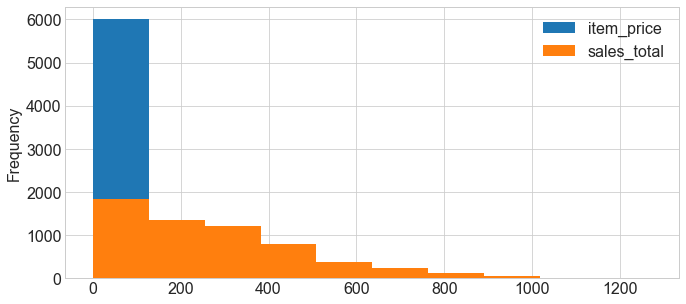

In [113]:
train.groupby(['store', 'month', 'item']).agg('mean').plot.hist()

<AxesSubplot:ylabel='Frequency'>

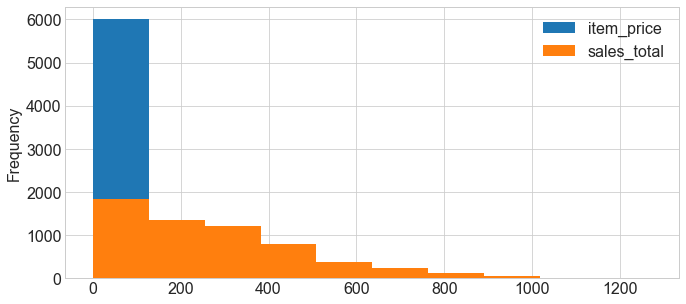

In [113]:
train.groupby(['store', 'month', 'item']).agg('mean').plot.hist()

<AxesSubplot:xlabel='store,month,item'>

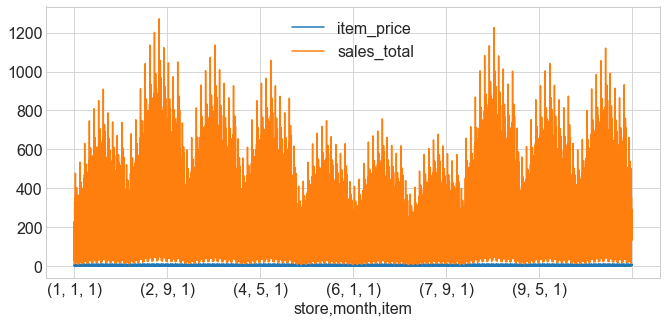

In [115]:
train.groupby(['store', 'month', 'item']).agg('mean').plot()

<AxesSubplot:xlabel='store,weekday,item'>

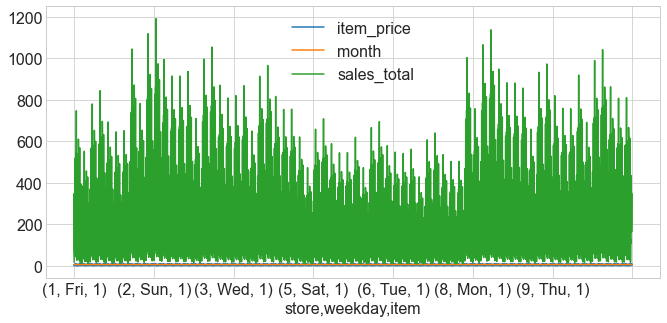

In [116]:
train.groupby(['store', 'weekday', 'item']).agg('mean').plot()